<a href="https://colab.research.google.com/github/ras1364/Run10SentenceBert/blob/main/SentenceBertMaxPooling4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this code, the sentences individually + Sentence-BERT encoder +  MaxPooling  + NLP network **

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving X_test1.csv to X_test1.csv
Saving X_train1.csv to X_train1.csv
Saving y_test1.csv to y_test1.csv
Saving y_train1.csv to y_train1.csv


In [ ]:
num = "1"
X_test = pd.read_csv("/content/X_test"+num+".csv")
X_train = pd.read_csv("/content/X_train"+num+".csv")
y_test = pd.read_csv("/content/y_test"+num+".csv")
y_train = pd.read_csv("/content/y_train"+num+".csv")

In [ ]:
max_length = 100
max_sentence = 50
# for x in range(0,len(X_train)):
#   line = X_train.loc[x].at["text"]
#   if max_length < len(line.split()) :
#     max_length = len(line.split())

print(max_length)


100


In [ ]:
from gensim.parsing.preprocessing import remove_stopwords

def preprocess(text):
  return remove_stopwords(text)

X_train["stemmed_text_data"] = X_train["text"].map(preprocess)
X_test["stemmed_text_data"] = X_test["text"].map(preprocess)

In [ ]:
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')


In [ ]:
def percent_complete(step, total_steps, bar_width=60, title="", print_perc=True):
    import sys

    # UTF-8 left blocks: 1, 1/8, 1/4, 3/8, 1/2, 5/8, 3/4, 7/8
    utf_8s = ["█", "▏", "▎", "▍", "▌", "▋", "▊", "█"]
    perc = 100 * float(step) / float(total_steps)
    max_ticks = bar_width * 8
    num_ticks = int(round(perc / 100 * max_ticks))
    full_ticks = num_ticks / 8      # Number of full blocks
    part_ticks = num_ticks % 8      # Size of partial block (array index)

    disp = bar = ""                 # Blank out variables
    bar += utf_8s[0] * int(full_ticks)  # Add full blocks into Progress Bar

    # If part_ticks is zero, then no partial block, else append part char
    if part_ticks > 0:
        bar += utf_8s[part_ticks]

    # Pad Progress Bar with fill character
    bar += "▒" * int((max_ticks/8 - float(num_ticks)/8.0))

    if len(title) > 0:
        disp = title + ": "         # Optional title to progress display

    # Print progress bar in green: https://stackoverflow.com/a/21786287/6929343
    disp += "\x1b[0;32m"            # Color Green
    disp += bar                     # Progress bar to progress display
    disp += "\x1b[0m"               # Color Reset
    if print_perc:
        # If requested, append percentage complete to progress display
        if perc > 100.0:
            perc = 100.0            # Fix "100.04 %" rounding error
        disp += " {:6.2f}".format(perc) + " %"

    # Output to terminal repetitively over the same line using '\r'.
    sys.stdout.write("\r" + disp)
    sys.stdout.flush()

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
import tensorflow as tf

def encode(text, maxlen,maxSentence,mtitle):
  embeddings=[]
  counter = 1
  for row in text:
    embedding =[]
    counter+=1
    sentecesCoutner = 0
    percent_complete(counter, len(text), title=mtitle)
    for sent in sent_tokenize(row):
      sentecesCoutner+=1
      if(sentecesCoutner<maxSentence):
        embedding.append(sbert_model.encode(sentences=sent ,convert_to_numpy=True ))

    loop = 50 - len(embedding)
    for x in range(loop):
      embedding.append(np.zeros([384],dtype=float))
    embeddings.append(embedding)

  return embeddings

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import time

In [ ]:
startedTime = time.time()
X_train_encoded = encode(X_train.stemmed_text_data,max_length,max_sentence,"X_train_embedding")
endTime= time.time()
print("\nElapsed Time : ", endTime - startedTime, "sec or ",(endTime - startedTime)/60,"min")

X_train_embedding: ████████████████████████████████████████████████████████████ 100.00 %
Elapsed Time :  256.1089243888855 sec or  4.268482073148092 min


In [ ]:
startedTime = time.time()
X_test_encoded = encode(X_test.stemmed_text_data,max_length,max_sentence,"X_test_embedding")
endTime= time.time()
print("\nElapsed Time : ", endTime - startedTime, "sec or ",(endTime - startedTime)/60,"min")

X_test_embedding: ████████████████████████████████████████████████████████████▎ 100.00 %
Elapsed Time :  59.612637758255005 sec or  0.9935439626375834 min


In [ ]:
X_train_embedding_squeezed = np.squeeze(X_train_encoded)
X_test_embedding_squeezed = np.squeeze(X_test_encoded)

In [ ]:
print("X_train.shape = " , np.shape(X_train_embedding_squeezed), " y_train.shape = ", y_train["deceptive"].shape)
print("X_test.shape = " , np.shape(X_test_embedding_squeezed), " y_test.shape = ", y_test["deceptive"].shape)

X_train.shape =  (1280, 50, 384)  y_train.shape =  (1280,)
X_test.shape =  (320, 50, 384)  y_test.shape =  (320,)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense,MaxPooling1D
import keras

# define and fit the final model
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
   ]
model = Sequential()
model.add(keras.Input(shape=(50,384,)))
model.add(MaxPooling1D(pool_size=(50)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling1d (MaxPooling1D  (None, 1, 384)           0         
 )                                                               
                                                                 
 dense (Dense)               (None, 1, 64)             24640     
                                                                 
 dense_1 (Dense)             (None, 1, 32)             2080      
                                                                 
 dense_2 (Dense)             (None, 1, 1)              33        
                                                                 
Total params: 26,753
Trainable params: 26,753
Non-trainable params: 0
_________________________________________________________________


In [ ]:
startedTime = time.time()
model.fit(X_train_embedding_squeezed,y_train.deceptive, epochs=50, batch_size=64, verbose=1)
endTime= time.time()
print("\nElapsed Time : ", endTime - startedTime, "sec or ",(endTime - startedTime)/60,"min")

Epoch 1/50
20/20 [==============================] - 2s 11ms/step - loss: 0.6915 - accuracy: 0.5234 - precision: 0.5221 - recall: 0.5531
Epoch 2/50
20/20 [==============================] - 0s 8ms/step - loss: 0.6820 - accuracy: 0.5781 - precision: 0.5542 - recall: 0.7984
Epoch 3/50
20/20 [==============================] - 0s 8ms/step - loss: 0.6723 - accuracy: 0.6070 - precision: 0.6065 - recall: 0.6094
Epoch 4/50
20/20 [==============================] - 0s 7ms/step - loss: 0.6557 - accuracy: 0.6328 - precision: 0.6562 - recall: 0.5578
Epoch 5/50
20/20 [==============================] - 0s 8ms/step - loss: 0.6262 - accuracy: 0.7023 - precision: 0.6781 - recall: 0.7703
Epoch 6/50
20/20 [==============================] - 0s 7ms/step - loss: 0.5964 - accuracy: 0.7164 - precision: 0.7282 - recall: 0.6906
Epoch 7/50
20/20 [==============================] - 0s 6ms/step - loss: 0.5602 - accuracy: 0.7414 - precision: 0.7623 - recall: 0.7016
Epoch 8/50
20/20 [==============================] - 0s

In [ ]:
model.evaluate(X_test_embedding_squeezed, y_test.deceptive)

10/10 [==============================] - 0s 3ms/step - loss: 0.6252 - accuracy: 0.7312 - precision: 0.7342 - recall: 0.7250


[0.6252180337905884, 0.731249988079071, 0.7341772317886353, 0.7250000238418579]

In [ ]:
y_predicted = model.predict(X_test_embedding_squeezed)
y_predicted = y_predicted.flatten()

10/10 [==============================] - 0s 4ms/step


In [ ]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test.deceptive, y_predicted)
cm

array([[118,  42],
       [ 44, 116]])

Text(50.722222222222214, 0.5, 'Truth')

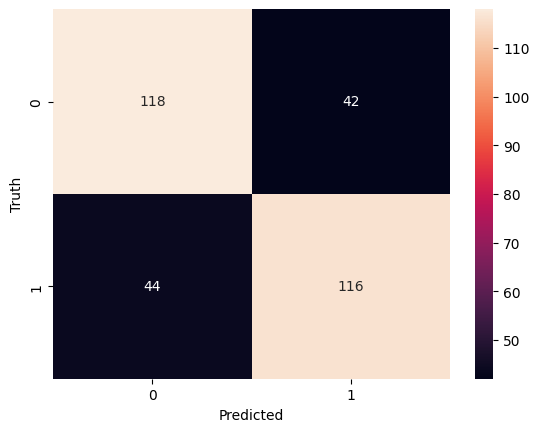

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test.deceptive, y_predicted))

              precision    recall  f1-score   support

           0       0.73      0.74      0.73       160
           1       0.73      0.72      0.73       160

    accuracy                           0.73       320
   macro avg       0.73      0.73      0.73       320
weighted avg       0.73      0.73      0.73       320

